# Análise de dados sobre saúde do sono e estilo de vida

### Insights sobre padrões de sono e hábitos diários

# Visão geral do projeto:
O Sleep Health and Lifestyle Dataset fornece insights detalhados sobre os padrões de sono, hábitos diários e fatores de estilo de vida dos indivíduos. Essa etapa do projeto compreende dados já tratados e organizados para facilitar as análises. 

Essa análise tem como objetivo produzir insights a partir de métricas essenciais como duração do sono, qualidade do sono, níveis de atividade física, estresse, categoria de IMC, saúde cardiovascular e presença de distúrbios do sono.

# Fontes dos dados

Os dados foram obtidos no kaggle através do [link](https://www.kaggle.com/code/winterbearballu/sleep-health-and-lifestyle-eda)

Obs: este conjunto de dados é gerado sinteticamente e se destina exclusivamente a propósitos ilustrativos e educacionais. Ele visa fornecer uma estrutura realista para explorar e analisar correlações entre sono, hábitos de estilo de vida e métricas de saúde.

# Modelagem

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    LabelEncoder, 
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
)

from src.config import DADOS_LIMPOS
from src.graficos import plot_coeficientes, plot_comparar_metricas_modelos
from src.models import organiza_resultados, RANDOM_STATE

sns.set_theme(palette="bright")

In [8]:
df = pd.read_parquet(DADOS_LIMPOS)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   Genero                  400 non-null    category
 1   Idade                   400 non-null    int8    
 2   Ocupacao                400 non-null    category
 3   Duracao_sono            400 non-null    float32 
 4   Qualidade_sono          400 non-null    float32 
 5   Nivel_atividade_física  400 non-null    int8    
 6   Nivel_estresse          400 non-null    int8    
 7   IMC                     400 non-null    category
 8   Frequencia_cardiaca     400 non-null    int8    
 9   Passos_diarios          400 non-null    int16   
 10  Disturbio_sono          400 non-null    category
 11  Sistolica               400 non-null    int16   
 12  Diastolica              400 non-null    int8    
dtypes: category(4), float32(2), int16(2), int8(5)
memory usage: 9.0 KB


## Estruturação do modelo

Realizando a análise com regressão logística com o mínimo de tratamento

In [11]:
# Separação do target das demais colunas

X = df.drop(columns="Disturbio_sono")
y = df["Disturbio_sono"]

In [12]:
# Codificando para obter um target numérico

le = LabelEncoder()

y = le.fit_transform(y)

y[:20]

array([1, 1, 1, 1, 0, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 0])

Agora que já foi observado o comportamento do modelo inicial, vamos partir para uma abordagem que busca resolver alguns problemas encontrados na análise exploratória.

Na análise exploratória, observamos que praticamente todas as colunas numéricas não estão com distribuição normal e com escalas muito diferentes, o que afeta a performance de modelos lineares.

Por esse motivo, além de para codificar colunas colunas categoricas ordinais e nominais, adicionaremos pré-tratamentos as colunas numéricas.

In [14]:
# Selecionar colunas para o pré-processamento

coluna_target = ["Disturbio_sono"]

colunas_categoricas_ordinais =["IMC"]

ordem_imc = [["Underweight", "Normal", "Overweight", "Obese"]]

colunas_categoricas_nominais = df.select_dtypes(include="category").columns.difference(colunas_categoricas_ordinais + coluna_target).to_list()

colunas_numericas= df.select_dtypes(include="number").columns.to_list()

In [15]:
# Construindo pipeline dos dados

preprocessamento_categoricas = ColumnTransformer(
    transformers=[
        ("ordinal_encoder", OrdinalEncoder(categories=ordem_imc), colunas_categoricas_ordinais),
        ("one_hot_encoder", OneHotEncoder(), colunas_categoricas_nominais)
    ],
    remainder="passthrough",
)

preprocessamento_completo = ColumnTransformer(
    transformers=[
        ("ordinal_encoder", OrdinalEncoder(categories=ordem_imc), colunas_categoricas_ordinais),
        ("one_hot_encoder", OneHotEncoder(), colunas_categoricas_nominais),
        ("StandardScaler", StandardScaler(), colunas_numericas),
    ],
    remainder="passthrough",
)

Visando realizar uma análise comparativa, adicionamos uma nova variável de pré-processamento que agora conta com o StandardScaler responsável por permitir um ajuste de escala aos dados.

In [17]:
regressors = {
    "DummyClassifier":{
        "preprocessor": None,
        "regressor": DummyClassifier(strategy="stratified"),
    },
    "Logistic_regression_cat":{
        "preprocessor": preprocessamento_categoricas,
        "regressor": LogisticRegression(max_iter=5000, solver="saga", class_weight="balanced"),
    },
    "Logistic_regression_completo":{
        "preprocessor": preprocessamento_completo,
        "regressor": LogisticRegression(max_iter=5000, solver="saga", class_weight="balanced"),
    },
}

Além disso, foi mudada a estrutura do código visando a análise comparativa das combinações de pré-processamentos associadas Regressão Logística e adicionado o tratamento de desbalanceamento que avaliaremos depois.

A entrada do regressor DummyClassifier é para se ter apenas um modelo de referência na avaliação de performance do modelo, ele aplica regras simples para prever as classes e não aprende padrão dos dados.

In [19]:
# Construindo a pipeline

pipelines = {
    nome: Pipeline(steps=[("preprocessor", estrutura["preprocessor"]), ("reg", estrutura["regressor"])])
    for nome, estrutura in regressors.items()
}

pipelines["Logistic_regression_cat"]

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinal_encoder',
                                                  OrdinalEncoder(categories=[['Underweight',
                                                                              'Normal',
                                                                              'Overweight',
                                                                              'Obese']]),
                                                  ['IMC']),
                                                 ('one_hot_encoder',
                                                  OneHotEncoder(),
                                                  ['Genero', 'Ocupacao'])])),
                ('reg',
                 LogisticRegression(class_weight='balanced', max_iter=5000,
                                    solver='saga'))])

In [20]:
# A outra mudança foi optar pela validação cruzada em vez do train-test split porque ela fornece uma avaliação mais robusta e confiável do modelo.

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

resultados = {
    nome: cross_validate(
        pipe,
        X,
        y,
        cv=kf,
        scoring=[
            "accuracy",
            "balanced_accuracy",
            "f1_weighted",
            "precision_weighted",
            "recall_weighted",
            "roc_auc_ovr",
            "average_precision",
        ],
    )
    for nome, pipe in pipelines.items()
}

C:\Users\Lenovo\anaconda3\envs\ml_aula\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Com a inclusão da validação cruzada, foram incluídas mais métricas para avaliar a performance dos modelos de classificação.

In [22]:
df_resultados = organiza_resultados(resultados)

df_resultados

,model,fit_time,score_time,test_accuracy,test_balanced_accuracy,test_f1_weighted,test_precision_weighted,test_recall_weighted,test_roc_auc_ovr,test_average_precision,time_seconds
0,DummyClassifier,0.003977,0.037318,0.6,0.351293,0.604167,0.608929,0.6,0.488867,0.330685,0.041295
1,DummyClassifier,0.0,0.043057,0.5375,0.277299,0.536742,0.536029,0.5375,0.50002,0.332896,0.043057
2,DummyClassifier,0.0,0.032885,0.6,0.366379,0.602782,0.606908,0.6,0.495947,0.331615,0.032885
3,DummyClassifier,0.001999,0.032125,0.475,0.298372,0.505296,0.544405,0.475,0.47472,0.327588,0.034125
4,DummyClassifier,0.001999,0.018659,0.5125,0.268582,0.509559,0.507237,0.5125,0.512686,0.343181,0.020658
5,Logistic_regression_cat,1.280366,0.088262,0.4375,0.415469,0.488664,0.616929,0.4375,0.636737,0.430041,1.368628
6,Logistic_regression_cat,2.065165,0.055437,0.5125,0.475575,0.557444,0.65125,0.5125,0.55598,0.40582,2.120602
7,Logistic_regression_cat,1.173242,0.059789,0.4,0.328784,0.463071,0.583893,0.4,0.480498,0.367866,1.233031
8,Logistic_regression_cat,1.26921,0.046879,0.4125,0.334531,0.46646,0.569925,0.4125,0.547626,0.436097,1.31609
9,Logistic_regression_cat,1.26713,0.031252,0.4625,0.413082,0.521481,0.659393,0.4625,0.63609,0.405906,1.298382


Na validação cruzada, o conjunto de dados é dividido em várias partes chamadas “dobras”. O modelo é treinado e testado repetidamente, cada vez usando uma dobra diferente como teste. 

Por isso, em vez de um único resultado, obtemos vários — um para cada dobra — que depois são combinados (por exemplo, pela média) para dar uma estimativa mais robusta do desempenho.

In [24]:
df_resultados.groupby("model").mean().sort_values("test_balanced_accuracy")

,fit_time,score_time,test_accuracy,test_balanced_accuracy,test_f1_weighted,test_precision_weighted,test_recall_weighted,test_roc_auc_ovr,test_average_precision,time_seconds
model,,,,,,,,,,
DummyClassifier,0.001595,0.032809,0.545,0.312385,0.551709,0.560701,0.545,0.494448,0.333193,0.034404
Logistic_regression_completo,0.062278,0.041159,0.42,0.349182,0.475918,0.597827,0.42,0.516918,0.384829,0.103437
Logistic_regression_cat,1.411023,0.056324,0.445,0.393488,0.499424,0.616278,0.445,0.571386,0.409146,1.467346


Dentre as métricas verificadas acima, pode-se observar ainda a influencia de dados desbalanceados.

Se formos considerar avaliar pelo DummyClassifier, obteve resultados melhores em algumas métricas porque tem a tendência de chutar a classe com maior proporção e, por isso, tem melhores métricas de acerto.

Com relação a acurácia, como estamos tratando de dados desbalanceados, o resultado mais preciso seria o de Acurácia Balanceada pois leva em conta a proporção das classes.

O Recall é a métrica que se deve mais atenção, ela reflete o nível de acerto dos positivos (Insonia ou Apneia) e penaliza quando o modelo detecta um falso negativo, ou seja, um individuo que detectado como "Nenhum distúrbio" quem na verdade está com o distúrbio do sono, negando a esse indivíduo o tratamento adequado. Está com resultado pior que o Dummy, pois está penalizando mais os erros do modelo.

Já a precisão, penaliza mais os falsos positivos, indicando que o modelo está errando pouco quando prevê distubio onde não há, justamente porque há poucos dados de disturbio.

Por último, a Curva ROC e Curva PRC tiveram melhores resultados para o modelo de Regressão Logística, com uma menor variância para a PRC que lida melhor com dados desbalanceados.

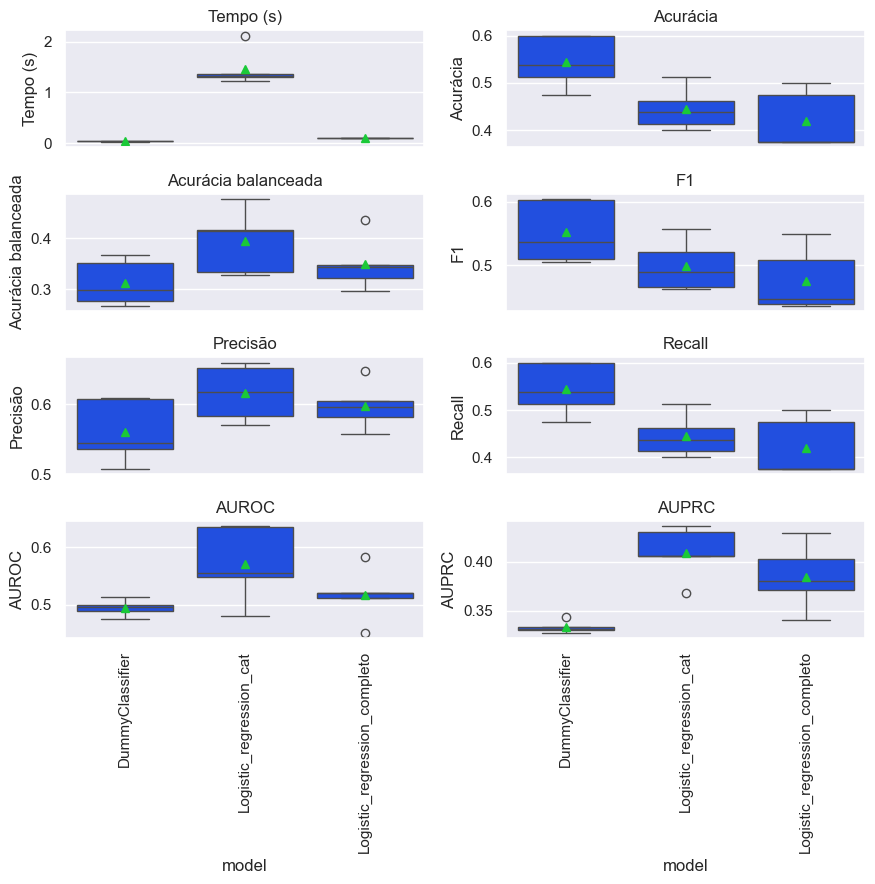

In [26]:
plot_comparar_metricas_modelos(df_resultados, multi_class=True)

Comparando o resultado dos modelos é possível observar que o aumento da complexidade não promoveu melhoria de performance, apenas com a codificação das variáveis categóricas foi melhor que o tratamento de escala.

Antes de publicar, foi realizado testes com o pré-processamento PowerTransformer nas variáveis numéricas que é mais robusto e permite a adequação dos dados a uma distribuição normal, além do ajuste de escala, mas mesmo assim, não foi suficiente para obter melhores resultados além de tornar o modelo mais instável com resultados inconsistentes, necessitando o aumento do número de iterações. Por esse motivo, optamos por um tratamento mais simples do StandardScaler.

## Conclusão

Nesse notebook realizamos alguns pré-processamentos visando corrigir alguns problemas encontrados na análise exploratória, onde foi observado colunas numéricas com problemas de escala e por não apresentar distribuição normal, o que, teoricamente, prejudica o desempenho dos modelos lineares.

Na prática, o modelo mais simples obteve resultado igual ou superior, mesmo realizando os pré-processamentos.

Para realizar comparações entre os pré-processamentos foi necessário realizarmos algumas modificações na estrutura do código. Além disso, utilizamos diferentes métricas para avaliar a performance dos modelos e também alguns recursos como o cross_validate ao invés do train_test_split.

## Próximas Análises:

Na próxima etapa, vamos avaliar a influência do desbalanceamento dos dados (preprocessamentos utilizando RandomUnderSampler, RandomOverSampler e SMOTE). Após identificar qual abordagem apresenta melhor desempenho, aplicaremos o Grid Search para realizar uma busca pelos melhores hiperparâmetros, maximizando as métricas de performance e garantindo que o modelo final não apenas lide adequadamente com o desbalanceamento, mas também opere em sua configuração ótima.

Por último, testar outro tipo de modelo linear (SGDClassifier), além de modelos baseados em árvores (DecisionTreeClassifier e RandomForestClassifier) e modelos baseados em Gradient Boosting (XGboost e LightGBM).